In [3]:
import pandas as pd

import os

import xml.etree.ElementTree as ET

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import skipgrams
from nltk.stem import WordNetLemmatizer
from nltk.data import load

import random
import functools
import string
import math
import json
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx
from networkx.readwrite import json_graph

import community

The visualization can be seen on: [GitHubPage](https://laertnuhu.github.io/MedDataVisualisation/)

# Data manipulation
In this section the xml data will be converted to a panda dataframe. This is done with the help of a Parser. The parser provides us with:
- getText(datalocation): the function is used to extract text tag values from every record. 
- addFeatureFromText(text,feature,skipString,nextLine,collectNext,featureKeyName): adds features derived from the text tag to the features directory 
- getDataframe(): returns a populated/empty Dataframe object. It depends on the number features that we already extracted
- removeEmptyEntries(dataframeObject, column): removes empty rows or the ones which contain "NaN"

The XMLDataframeParser methods can be found on: https://github.com/LaertNuhu/MedDataVisualisation/blob/master/py/dataManipulation.py

In [4]:
from py.dataManipulation import XMLDataframeParser

parser = XMLDataframeParser()
text = parser.getText("./data/smokingRecords.xml")
parser.addFeatureFromText(text, "HISTORY OF PRESENT ILLNESS :", "", True, True,"illness")
df = parser.getDataframe()
df_xml = parser.removeEmptyEntries(df,"illness")

# Data Normalisation

In this section we are going to start preparing for text normalisation. 
Here we will split the text recived from pandas dataframe into tokens. Transform them into lowercase and remove any characters which are non alfabetical. This is a decision that was made for the simple reason that nonalfabetical information is redundant in this case. For features like 'history course' numerical characters could be important for the analysis, but for the 'history of present illness' feature is not.

The text, which is on english, will be cleaned from stop words. At the end we also need only the stem of the words. 
By normalisation we try to have a clean and uniformal structure of text.

The above actions are all covered by [normalize and normalizeArray](https://github.com/LaertNuhu/MedDataVisualisation/blob/dev/py/normalize.py) functions.

An example of the functions used by these methods can be seen on the following blocks:

In [5]:
# import the Normalizer class from normalize package
from py.normalize import Normalizer
normalizer = Normalizer()

In [6]:
# we take a snippet from our dataframe
text = df_xml["illness"][1][:338]
print(text)

The patient is an 80-year-old male , who had a history of colon cancer in the past , resected approximately ten years prior to admission , history of heavy alcohol use , who presented with a two week history of poor PO intake , weight loss , and was noted to have acute on chronic Hepatitis by chemistries and question of pyelonephritis .


In [7]:
# tokenizer example
#text = "The 3 quick brown foxes are jumping over the fence. Dog barks. Now there are 3 foxes against the dog."
tokenizer = normalizer.tokenize(text)
print(tokenizer)

['The', 'patient', 'is', 'an', '80-year-old', 'male', ',', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', ',', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', ',', 'history', 'of', 'heavy', 'alcohol', 'use', ',', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'PO', 'intake', ',', 'weight', 'loss', ',', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'Hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis', '.']


In [8]:
# lowercase transformation
lowercaseTokens = normalizer.toLowerCase(tokenizer)
print(lowercaseTokens)

['the', 'patient', 'is', 'an', '80-year-old', 'male', ',', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', ',', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', ',', 'history', 'of', 'heavy', 'alcohol', 'use', ',', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'po', 'intake', ',', 'weight', 'loss', ',', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis', '.']


In [130]:
# remove punctuation from token array
noPunctuations = normalizer.removePunctuation(lowercaseTokens)
print(noPunctuations)

['the', 'patient', 'is', 'an', '80yearold', 'male', '', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', '', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', '', 'history', 'of', 'heavy', 'alcohol', 'use', '', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'po', 'intake', '', 'weight', 'loss', '', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis', '']


In [131]:
# remove non alphabetic characters
noAlpha = normalizer.removeNonAlpha(noPunctuations)
print(noAlpha)

['the', 'patient', 'is', 'an', 'male', 'who', 'had', 'a', 'history', 'of', 'colon', 'cancer', 'in', 'the', 'past', 'resected', 'approximately', 'ten', 'years', 'prior', 'to', 'admission', 'history', 'of', 'heavy', 'alcohol', 'use', 'who', 'presented', 'with', 'a', 'two', 'week', 'history', 'of', 'poor', 'po', 'intake', 'weight', 'loss', 'and', 'was', 'noted', 'to', 'have', 'acute', 'on', 'chronic', 'hepatitis', 'by', 'chemistries', 'and', 'question', 'of', 'pyelonephritis']


In [132]:
# remove stop words
noStopWords = normalizer.removeStopWords(noAlpha)
print(noStopWords)

['patient', 'male', 'history', 'colon', 'cancer', 'past', 'resected', 'approximately', 'ten', 'years', 'prior', 'admission', 'history', 'heavy', 'alcohol', 'use', 'presented', 'two', 'week', 'history', 'poor', 'po', 'intake', 'weight', 'loss', 'noted', 'acute', 'chronic', 'hepatitis', 'chemistries', 'question', 'pyelonephritis']


In [133]:
# get tokens stemm
stemmed = normalizer.stemTokens(noStopWords)
print(stemmed)

['patient', 'male', 'histori', 'colon', 'cancer', 'past', 'resect', 'approxim', 'ten', 'year', 'prior', 'admiss', 'histori', 'heavi', 'alcohol', 'use', 'present', 'two', 'week', 'histori', 'poor', 'po', 'intak', 'weight', 'loss', 'note', 'acut', 'chronic', 'hepat', 'chemistri', 'question', 'pyelonephr']


In [143]:
# get tokens lemma
lemmatizedTokens = normalizer.lemmatizeTokens(noStopWords)
print(lemmatized)

['patient', 'male', 'history', 'colon', 'cancer', 'past', 'resect', 'approximately', 'ten', 'years', 'prior', 'admission', 'history', 'heavy', 'alcohol', 'use', 'present', 'two', 'week', 'history', 'poor', 'po', 'intake', 'weight', 'loss', 'note', 'acute', 'chronic', 'hepatitis', 'chemistries', 'question', 'pyelonephritis']


In [144]:
# get verbs lemma
lemmatized = normalizer.lemmatizeVerbs(lemmatizedTokens)
print(lemmatized)

['patient', 'male', 'history', 'colon', 'cancer', 'past', 'resect', 'approximately', 'ten', 'year', 'prior', 'admission', 'history', 'heavy', 'alcohol', 'use', 'present', 'two', 'week', 'history', 'poor', 'po', 'intake', 'weight', 'loss', 'note', 'acute', 'chronic', 'hepatitis', 'chemistry', 'question', 'pyelonephritis']


# Data exploration
In this section we start with the first step of data analysis. Here we do intial data exploration analysis. 

Steps:
 1. Calculate how many tokens has the document
 2. which are the most frequent words
 3. calulate words frequency using tf-idf
 4. compare the results between 2 and 3
 5. which are the most frequent word pairs?
 6. do the same as 3 but for word pairs
 7. use skipgramms
 8. compare results


### 1. Total words count
The countWords function is used to find out how many tokens are on our dataset after cleaning it. 

In [14]:
def countWords(data,lemmatized,POS):
    count=0
    normalizedArray = normalizer.normalizeArray(data,lemmatized,POS)
    for tokenArray in normalizedArray:
        for token in tokenArray:
            count+=1
    return count

In [15]:
# count tokens
totalTokenCount = countWords(df_xml["illness"],False,False)
print('Total tokens: %d' % (totalTokenCount))

Total tokens: 31632


### 2a. Word occurence process example
1. Create a CountVectorizer Object

In [16]:
vectorizer = CountVectorizer()

2. fit data and transform it to a document term matrix

In [17]:
# count vectorizer ignores every token with a length smaller than 2
bag_of_words = vectorizer.fit_transform(["There is a cat","There is a dog","Dog barks"])
print(bag_of_words.toarray())

[[0 1 0 1 1]
 [0 0 1 1 1]
 [1 0 1 0 0]]


3. Sum matrix verticaly

In [18]:
# axis 0 is the vertical axis
# returns a matrix
sum_words = bag_of_words.sum(axis=0)
print(sum_words)

[[1 1 2 2 2]]


4. Map tokens to the sum_words list

In [19]:
# vocabulary_.items() returns a dictionary with the token and its index
# tokens are sorted alphabeticaly in the matrix
vectorizer.vocabulary_.items()

dict_items([('there', 4), ('is', 3), ('cat', 1), ('dog', 2), ('barks', 0)])

In [20]:
# map token to ocunt
words_frequency = []
for token,idx in vectorizer.vocabulary_.items():
    words_frequency.append((token,sum_words[0,idx]))
    print('count of "%s" is %s' % (token,sum_words[0,idx]))

count of "there" is 2
count of "is" is 2
count of "cat" is 1
count of "dog" is 2
count of "barks" is 1


In [21]:
# sort words frequency list
print("Unsorted: %s" % words_frequency)
words_frequency_sorted = sorted(words_frequency, key = lambda x: x[1], reverse=True)
print("Sorted after count: %s" % words_frequency_sorted)

Unsorted: [('there', 2), ('is', 2), ('cat', 1), ('dog', 2), ('barks', 1)]
Sorted after count: [('there', 2), ('is', 2), ('dog', 2), ('cat', 1), ('barks', 1)]


In [22]:
# limit the list output
# based on tokens
n = 2 # the first two tokens
print(words_frequency_sorted[:n])
# based on count
t = 2 # tokens with count higher or the same as 2
print(list(filter(lambda x: x[1]>=t,words_frequency_sorted)))

[('there', 2), ('is', 2)]
[('there', 2), ('is', 2), ('dog', 2)]


### 2b. Words occurency using [SKlearn Bib](https://scikit-learn.org/stable/)
Quick Info:
Using SKlearn CountVectorizer to count word frequencies and as tokenizer we use the normalize function (can be found by data normalisation paragraph). 
The reason for that is because CountVectorizer doesn't support stemming out of the box. We assign the tokenizer parameter with our normalize function which gives stemmed/lemmatized tokens as a result

Content: 
1. getFirstNWords()
2. getFirstWordsWithCountGreater()
3. buildPlot()
4. Most frequent words Graph

### 2b 1. getFirstNWords function: 
- takes the vectorizer, the documents form panda dataframe and the number of rows which will be included
- is the function which does the fit and transformation of the data. 
- the sorting is also done here, giving the top most frequent tokens, n-grams

Parameter explenation:
- vec: takes an Vectorizer Object
- data: takes a data stream. In our case we give here as input the pandas dataframe colum wich we want to analyse
- n: stands for the number of results that we want to have. For example the first 10 most frequent words would mean a n of 10

returns a list of zips. (a,b) were a is the word/words and b is the count

In [23]:
def getFirstNWords(vec,data,n):
    bag_of_words = vec.fit_transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq_sorted[:n]

### 2b 2. getFirstWordsWithCountGreater function:
- takes the vectorizer, the documents form panda dataframe and the number of rows which will be included
- is the function which does the fit and transformation of the data.
- the sorting is also done here, giving the top most frequent tokens whose count is grater than the threshold t, n-grams

Parameter explenation:
- vec: takes an Vectorizer Object
- data: takes a data stream. In our case we give here as input the pandas dataframe colum wich we want to analyse
- t: stands for the threshold. For example we want words that have a count grater than 10, in wich case t would be 10

returns a list of zips. (a,b) were a is the word/words and b is the count

In [24]:
def getFirstWordsWithCountGreater(vec,data,t):
    bag_of_words = vec.fit_transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return filter(lambda x: x[1]>=t,words_freq_sorted)

### 2b 3. buildPlot function:
the buildPlot function as the name already says it creates a plot.

Parameter explenation:
- freqWords: is a List containing elements (a,b) where a is one word, or many words depending what we want to count and b is the count of the word/words
- tfidf: if true the x axis is shown as tfidf
- title: a string used for the graph title

In [25]:
def buildPlot(freqWords,tfidf,title):
    labels, values = zip(*freqWords)
    # reverse the indexes -> the top is the most frequent token
    indexes = np.arange(len(labels))[::-1]
    # Set 15:12 figure size
    plt.figure(figsize=(15,12))
    plt.yticks(indexes, labels)
    plt.barh(indexes, values, color='#86bf91')
    # Text on the side of each barplot
    for i in range(len(indexes)):
        plt.text(x = round(values[i],2)+0.1 , y = indexes[i]-0.1, s = round(values[i],2), size = 12)
    ax = plt.gca()
    # Draw vertical axis lines
    for tick in ax.get_xticks():
        plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    # set vertical axis title
    plt.ylabel('Tokens',fontsize=16)
    # set plot title 
    plt.title(title,fontsize=20,fontweight="bold")
    if(tfidf):
        plt.xlabel('TF-IDF',fontsize=16)
    else:
        plt.xlabel('Count',fontsize=16)
    plt.show()

### 2b 4. Most frequent words graph

Firstly we create a CountVectoizer Object. Then we get the top 10 most frequent words using getFirstNWords function. Last step is to visualize the result using a bar plot.

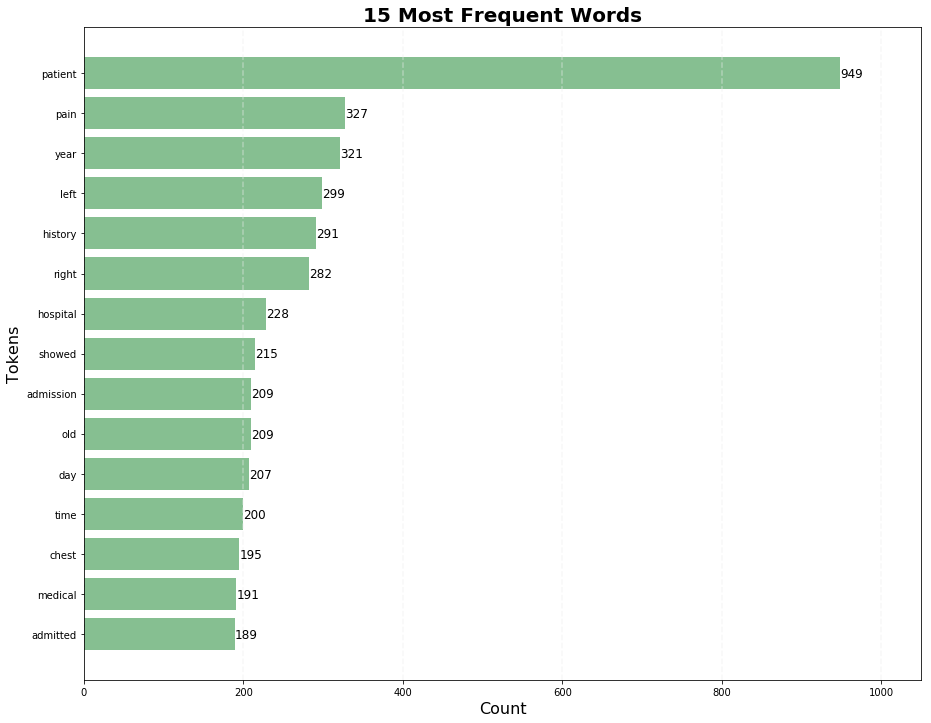

In [26]:
# Firstly creating a CountVectoizer Object
vec = CountVectorizer(tokenizer=lambda text: normalizer.normalize(text, True,False))
mostFreqWords = getFirstNWords(vec,df_xml.illness,15)
buildPlot(mostFreqWords,False,"15 Most Frequent Words")

### 3. TFIDF analysis
TF-IDF gives high scores to terms occurring in only very few documents, and low scores for terms occurring in many documents, so its roughly speaking a measure of how discriminative a term is in a given document.

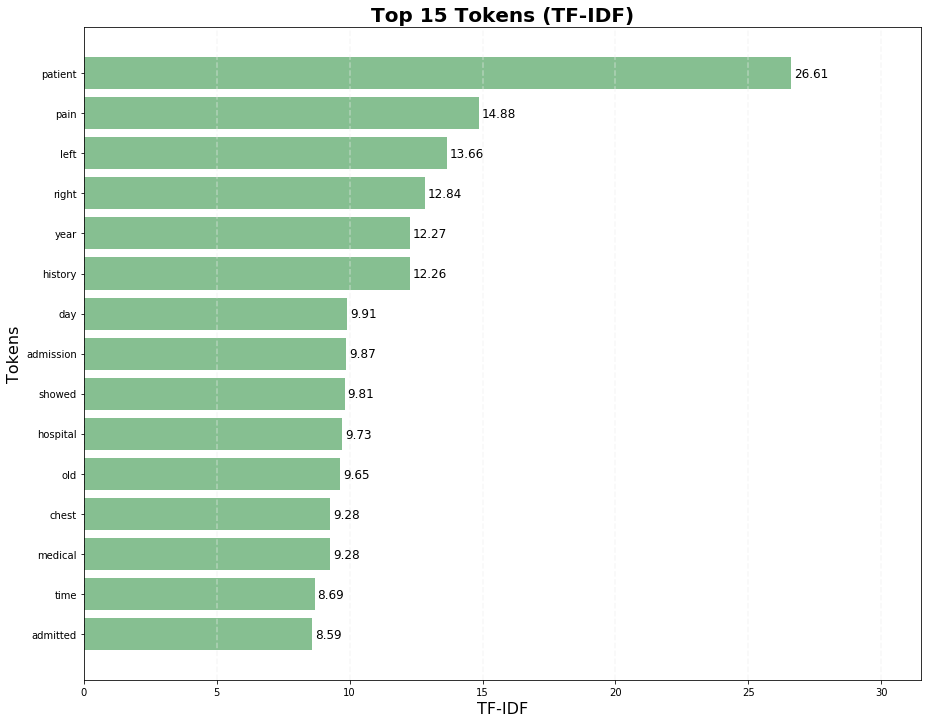

In [27]:
vecTfidf = TfidfVectorizer(tokenizer=lambda text: normalizer.normalize(text, True,False))
mostFreqWordsTFIDF = getFirstNWords(vecTfidf,df_xml.illness,15)
buildPlot(mostFreqWordsTFIDF,True,"Top 15 Tokens (TF-IDF)")

## TFIDF method for comparison

### 4. Word pairs (2-grams) occurency
In this section we will compute word frequencies and the tfidf scores for 2 grams.

The structure is the same as 1-gram but in this case we will change the ngram_range to (2,2). That will result in counting only 2-grams.

##### 2-Gram Frequency 

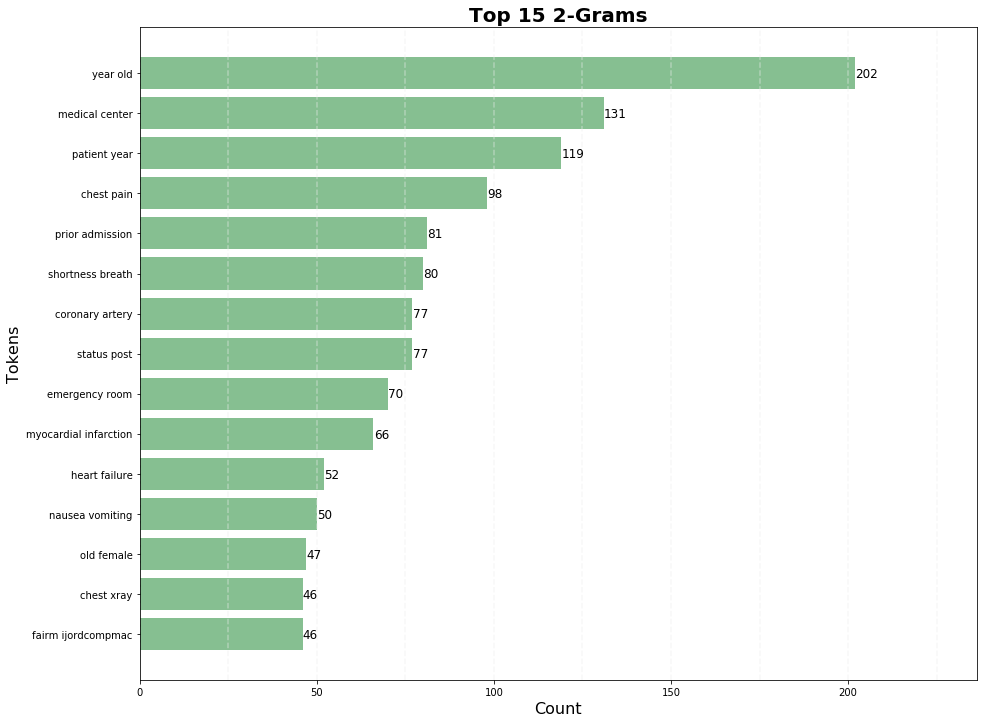

In [28]:
vec2Gram = CountVectorizer(
        tokenizer=lambda text: normalizer.normalize(text, True,False),
        ngram_range=(2, 2)
        )
mostFreq2Grams = getFirstNWords(vec2Gram,df_xml.illness,15)
buildPlot(mostFreq2Grams,False, "Top 15 2-Grams")

### 5. 2-gram TfIdf analysis

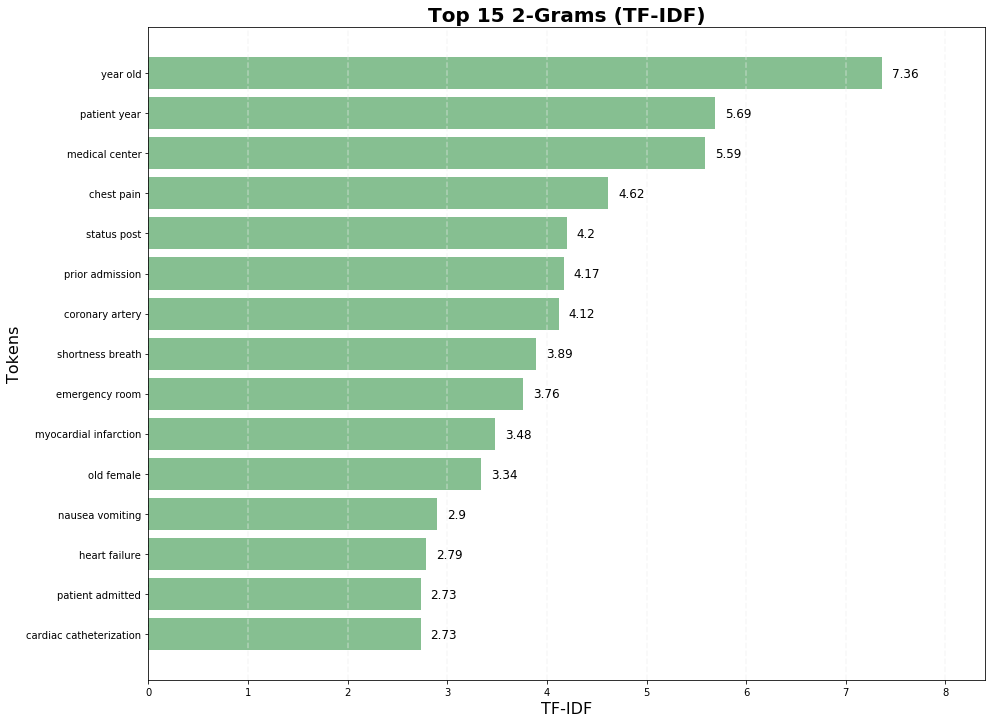

In [29]:
vecTFIDF2Gram = TfidfVectorizer(
        tokenizer=lambda text: normalizer.normalize(text, True,False),
        ngram_range=(2, 2)
        )
mostFreqTFIDF2Grams = getFirstNWords(vecTFIDF2Gram,df_xml.illness,15)
buildPlot(mostFreqTFIDF2Grams,True,"Top 15 2-Grams (TF-IDF)")

### 6. Skipgrams
#### 6.a Customize the Vectorizer object

The provided code is taken from a [Stackoverflow post](https://stackoverflow.com/questions/39725052/is-there-any-way-implementing-skip-gram-with-scikit-learn) and some minor modifications are done. 
We don't need to use the stop words in the build_analyzer function as our tokeizer already does stop words removal. 

##### Important methods used by skipgram implementation
- sliding_window(k,tokens)
    - k represents the n in n-grams
    - tokens represents a list of words
    - Example: sliding_window(3,["hello","miki","my","name"]) gives us a 2 3-grams. ("hello","miki","my") and ("miki","my","name")
- pluck(index_array, ngram_zip):
    - the index_array gives us the indexes which will be taken into consideration. For Example:
    - array = ["one","2","three"] and the index_array = [0,2] then the array[1] value will be excluded
- compose(f,g)(x):
    - composes functions -> f(g(x))

In [30]:
# import the toolz packages
from toolz import itertoolz, compose
from toolz.curried import map as cmap, sliding_window, pluck

In [31]:
# sliding window -> creates n-grams from tokens array
tokensArray = ["hello","miki","my","name","is"]
n_grams = sliding_window(3,tokensArray)
print(list(n_grams))

[('hello', 'miki', 'my'), ('miki', 'my', 'name'), ('my', 'name', 'is')]


In [32]:
# pluck removes elements from a zip
print(list(pluck([0,2],sliding_window(3,tokensArray))))

[('hello', 'my'), ('miki', 'name'), ('my', 'is')]


In [33]:
# maps values
print(list(cmap(' '.join ,pluck([0,2],sliding_window(3,tokensArray)))))

['hello my', 'miki name', 'my is']


In [34]:
class SkipGramVectorizer(CountVectorizer):
    # modify build_analyzer
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc))

    # responsible for skipgrams
    def _word_skip_grams(self, tokens):
        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(3))(tokens)

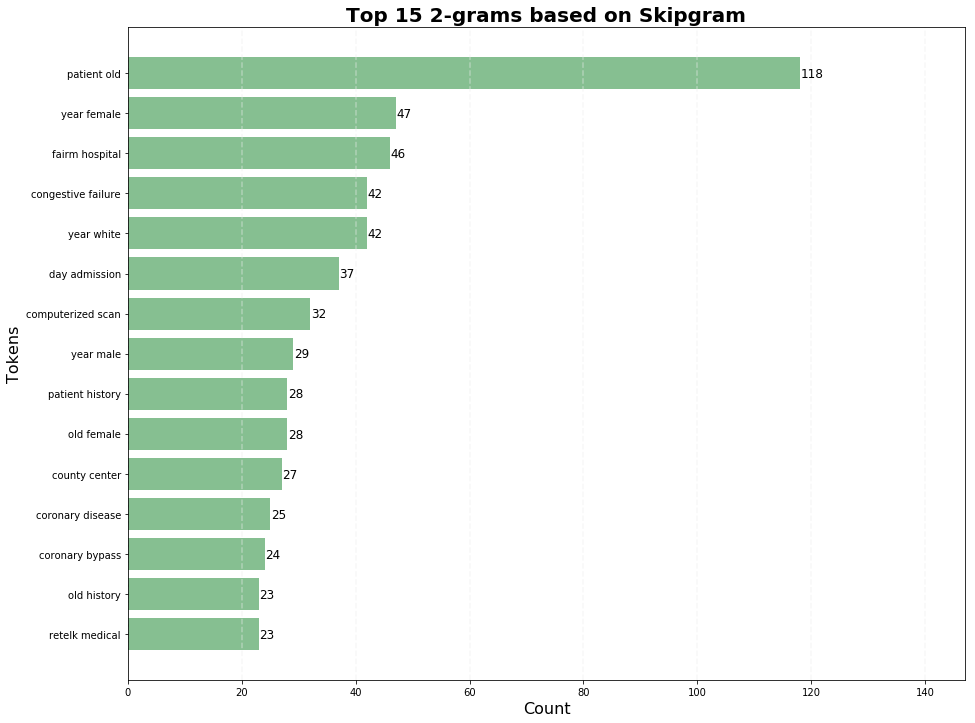

In [35]:
# initialize the new Vectorizer 
vec2SkipGram = SkipGramVectorizer(
    tokenizer=lambda text: normalizer.normalize(text, True,False)
)

mostFreq2SkipGrams = getFirstNWords(vec2SkipGram,df_xml.illness,15)
buildPlot(mostFreq2SkipGrams,False,"Top 15 2-grams based on Skipgram")

##### Problem with this implementation:
Problem here is with the pluck method. It is static, meaning that if we want to skip the first element or the last element and not allways the middle ones it does not work. So with this implementation we are nor really gaining extra 2-grams but we are getting different 2-grams. 
Example: 
- "this is an example sentence"
- 2-grams wihtout using the skipgrams implementation:
    - ('this', 'is'), ('is', 'an'), ('an', 'example'), ('example', 'sentence')
- the 2-grams formed using this skipgrams implementation:
    - ('this','an'), ('is','example'), ('an', 'sentence')
- desired outcome: 
    - a union between the two results:
        - ('this', 'is'), ('is', 'an'), ('an', 'example'), ('example', 'sentence'), ('this','an'), ('is','example'), ('an', 'sentence')

###### custom tfidfVectorizer
The same steps as before are followed

In [36]:
# the implemntation of the tfidf vectorizer is the same 
# as by the count vectorizer
class SkipGramTFIDFVectorizer(TfidfVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc))

    def _word_skip_grams(self, tokens):
        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(3))(tokens)

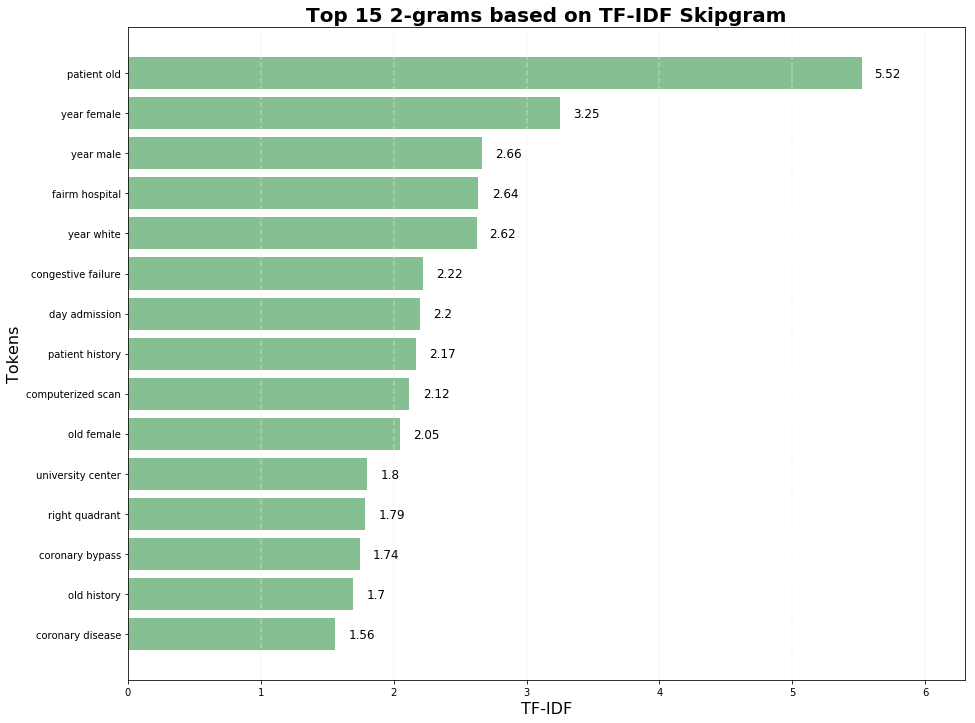

In [37]:
vecTFIDF2SkipGram = SkipGramTFIDFVectorizer(
    tokenizer=lambda text: normalizer.normalize(text, True,False)
)

mostFreqTFIDF2SkipGrams = getFirstNWords(vecTFIDF2SkipGram,df_xml.illness,15)
buildPlot(mostFreqTFIDF2SkipGrams,True,"Top 15 2-grams based on TF-IDF Skipgram")

#### 6.b Provide a custom analyzer function
In this phase we will use a combination of nltk skipgram and assign it as an analyser function. We also need to use the [normalizeArray](https://github.com/LaertNuhu/MedDataVisualisation/blob/dev/py/normalize.py) function because in this case we will firstly tokenize and normalize then we will create the vectorizer.

Here we create the skipper funtion. We take skipgrams function from nltk.util. The skipgrams function accepts 2 parameters.
n: is the number of n-grams. Minimum is 2 because using skipgrams for 1-grams does not bring any new information. 
k: is the number of allowed tokens to be skiped. It can be randomized (can be in the scale of 0 and windows_size) but for this implementation we give it a fixed value of 10. Increasing this number does not allways imply that the number of the extracted n-grams will be higher. 

In [38]:
window_size = 5
# we create a partial function in order to minimize the number of
# parameters the function requires
# a partial function out of skipgram function is not a requirment but 
# it make it easier for us to implement on the following steps
skipper = functools.partial(skipgrams, n=2, k=window_size)

In [39]:
testSentence = "this is an example sentence".split()
# partial function wich requires only one fucntion
print(list(skipper(testSentence)),"\n")
# nltk function wich requires 3 parameters
print(list(skipgrams(testSentence,2,1)))

[('this', 'is'), ('this', 'an'), ('this', 'example'), ('this', 'sentence'), ('is', 'an'), ('is', 'example'), ('is', 'sentence'), ('an', 'example'), ('an', 'sentence'), ('example', 'sentence')] 

[('this', 'is'), ('this', 'an'), ('is', 'an'), ('is', 'example'), ('an', 'example'), ('an', 'sentence'), ('example', 'sentence')]


In [40]:
# this function gives a better formating
def customAnalyser(token):
    return compose(cmap(' '.join),skipper)(token)

Firsly we need to apply the normalizeArray function to our data and we save that to a variable called text. We will be able to use this varible multiple times.

In [41]:
text = normalizer.normalizeArray(df_xml.illness,True,False)

The next 3 lines are the same as what we saw before. Also we create a vectorizer object. In this case we define the analyser to be skipper. Than we get the list of zips by using the getFirstNWords function and give that as an input to the bulidPlot function. 

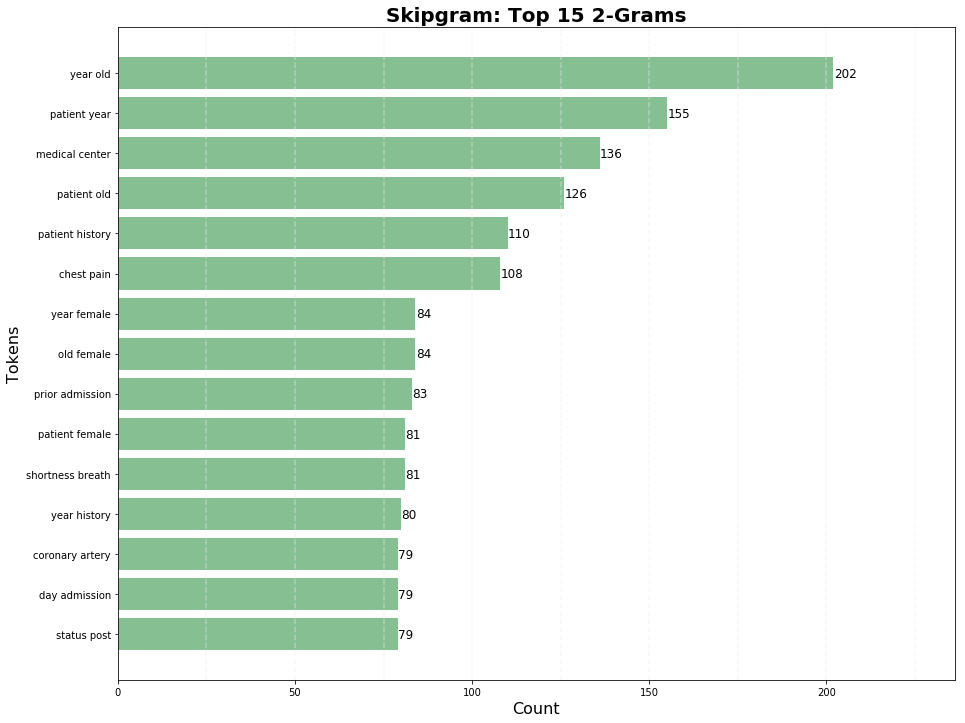

In [42]:
vecModAnalyzer = CountVectorizer(analyzer=customAnalyser)
mostFreq2SkipGramsNewAnalyzer = getFirstNWords(vecModAnalyzer,text,15)
buildPlot(mostFreq2SkipGramsNewAnalyzer,False, "Skipgram: Top 15 2-Grams")

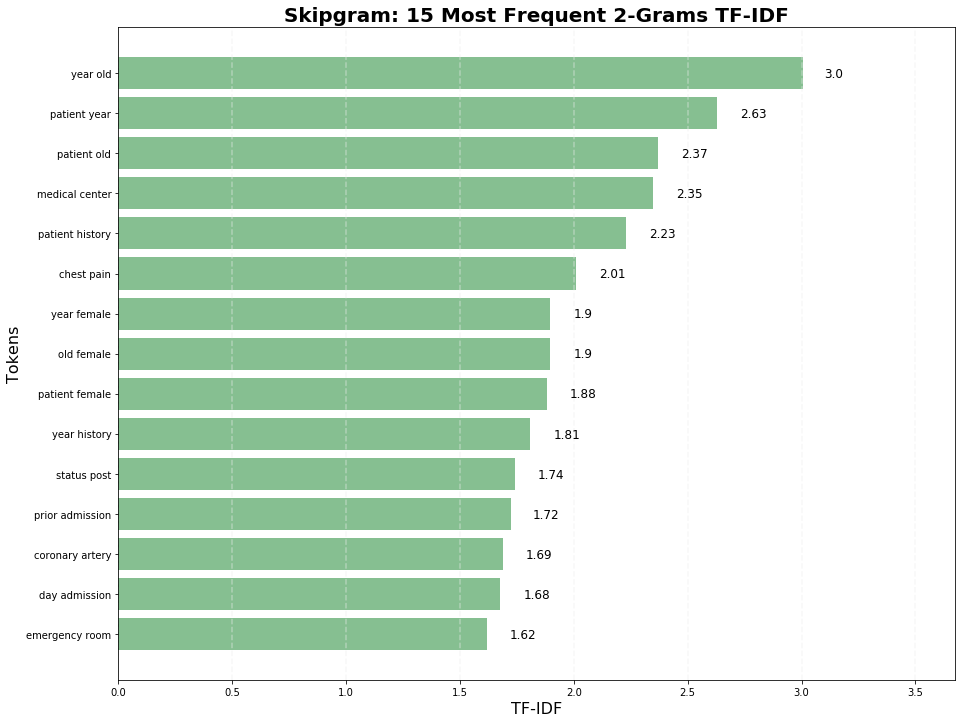

In [43]:
# now the same can be done also for the tfidf method
vecModAnalyzerTFIDF = TfidfVectorizer(analyzer=customAnalyser)
mostFreq2SkipGramsNewAnalyzerTFIDF = getFirstNWords(vecModAnalyzerTFIDF,text,15)
buildPlot(mostFreq2SkipGramsNewAnalyzerTFIDF,True,"Skipgram: 15 Most Frequent 2-Grams TF-IDF")

#### Check the Toy examlpe for the test dataset example, in order to explain

# Text Network Analysis
In this section we will focus on the construction of networks.
In order to construct networks we use a python package called [NetworkX](https://networkx.github.io/documentation/stable/index.html). 
The network data is derived form the the results of n-gram/skipgram analysis. 

##### 1. Create a example network and visualize it
Focus: create a network based on a small section of the data gained from the n-gram/skipgram analysis.

In [44]:
# take the 10 first entries from mostFreq2SkipGramsNewAnalyzer
d = mostFreq2SkipGramsNewAnalyzer[:10]
print(d)

[('year old', 202), ('patient year', 155), ('medical center', 136), ('patient old', 126), ('patient history', 110), ('chest pain', 108), ('year female', 84), ('old female', 84), ('prior admission', 83), ('patient female', 81)]


addData: 
- description: maps n-grams to network nodes and edges (the frequency of n-gram is the edge weight).
- parameters:
    - data: a list of zips, which contain in the first position the 2-gram and in the second position the frequency
    - graph: a graph object from NetworkX
- returns: a graph object with nodes and edges

In [45]:
# functions maps data from skipgram/ngram analysis to graph data
def addData(data,graph):
    for element in data:
        nodes = element[0].split()
        graph.add_edge(nodes[0],nodes[1],weight=element[1])
    return graph

createNetwork:
- description: creates an empty graph object and returns a completed graph.
- parameters: 
    - data: a list of zips, which contain in the first position the 2-gram and in the second position the frequency
- returns: a graph object

In [46]:
# create and populate a network
def createNetwork(data):
    # create an empty graph
    G = nx.Graph()
    # add data to graph
    addData(d,G)
    return G

rescale:

- description: normalizes values based on min-max normalization method
- parameters: 
    - value: the value to be normalized
    - minV: the minimal value on the set of the values
    - maxV: the maximal value on the value set
- returns: a number which is element of [0,1]   

In [47]:
# a function to rescale/adjust values based in min-max normalization
def rescale(value, minV, maxV):
    if(minV == maxV):
        return 0.5
    rescaled = (value - (minV-1)) / (maxV - minV)*10
    return rescaled;

vizualizeNetwork:

- description: visiualizes a network using matplotlib
- parameters: 
    - data: a list of zips, which contain in the first position the 2-gram and in the second position the frequency
    - hasEdgeLabel: a boolean parameter which is used to show/hide the edge labels
- returns: a network visualization    

In [47]:
def visualizeNetwork(data,hasEdgeLabels=False):   
    G = createNetwork(data)
    # define plot properties
    plt.figure(figsize=(15,10))
    # define positions
    pos = nx.spring_layout(G, k=5/math.sqrt(G.order()),iterations=5)
    # draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=5000,alpha=0.5, node_color="green")
    # add weights to a list
    weightsList = []
    for edge in G.edges:
        weight = G[edge[0]][edge[1]]["weight"]
        weightsList.append(weight)
    # we rescale the edge weight to be in [0,11]     
    maxVal = max(weightsList)
    minVal = min(weightsList)
    rescaledVal = functools.partial(rescale, maxV=maxVal, minV=minVal)
    weightsList=list(map(rescaledVal,weightsList))
    # draw edges
    nx.draw_networkx_edges(G, pos, edge_color="#555555",alpha=0.8, width=weightsList)
    # draw node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    if hasEdgeLabels:
        # get edge labels
        edge_labels = nx.get_edge_attributes(G,'weight')
        # draw edge labels
        nx.draw_networkx_edge_labels(G, pos, font_size=12, font_family='sans-serif',edge_labels=edge_labels,label_pos=0.3)
    
    # hide axis
    plt.axis('off')
    # show plot
    plt.show()

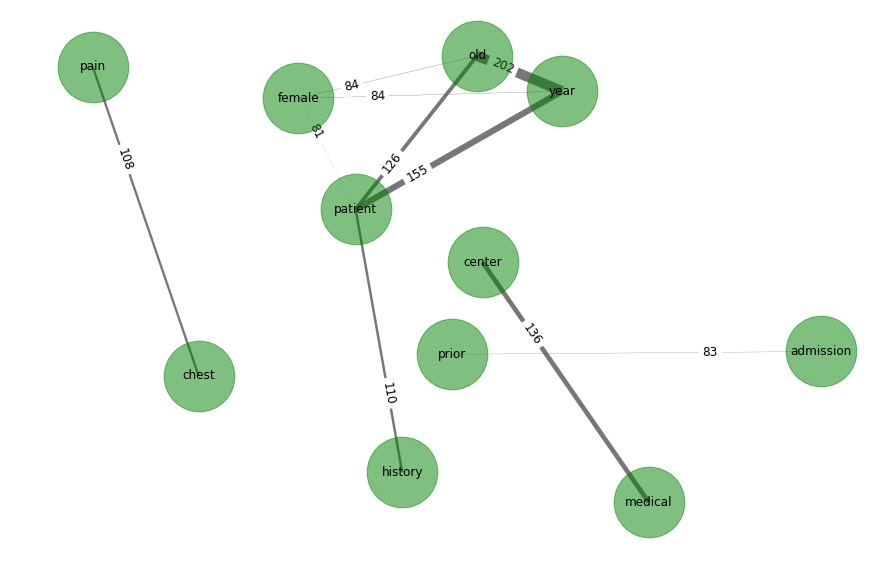

In [59]:
# visualize network
visualizeNetwork(d,True)

###### 2. create a network from the hole dataset
In this section we will create a network based on the entire dataset 

createDataFrame:
- description: networkX has default functions which can turn a pandas dataframe into a network dataset. For that reason we map the results from the n-gram/skipgram analysis into a pandas dataframe. 
- parameters:
    - data: a list of zips, which contain in the first position the 2-gram and in the second position the frequency
- returns: a pandas dataframe with the following columns:
    1. Node1 -> the source
    2. Node2 -> the target
    3. Weigth -> the edge weigth

In [48]:
def createDataframe(data):
    node1 = []
    node2 = []
    weight = []
    for entry in data:
        nodes = entry[0].split()
        node1.append(nodes[0])
        node2.append(nodes[1])
        weight.append(entry[1])
    df = pd.DataFrame()
    df['Node1']=node1
    df['Node2']=node2
    df['Weight']= weight
    return df

We create a vectorizer object, based on which we fit the data and transform it using the getFirstWordsWithCountGreater method (see chapter data exploration 2b). 
The dataframe is saved into a variable (df_graph) and print only the first 10 results

In [110]:
vectorizerForSkipgrams = CountVectorizer(analyzer=customAnalyser)
networkData = getFirstWordsWithCountGreater(vectorizerForSkipgrams,text,0)
df_graph = createDataframe(networkData)
print(df_graph[:10])

     Node1      Node2  Weight
0     year        old     202
1  patient       year     155
2  medical     center     136
3  patient        old     126
4  patient    history     110
5    chest       pain     108
6     year     female      84
7      old     female      84
8    prior  admission      83
9  patient     female      81


we use the default method from networkX from_pandas_edgelist in order to create a network object from the pandas dataframe

In [111]:
GF = nx.from_pandas_edgelist(df_graph, 'Node1', 'Node2', ["Weight"])

##### 3. Analyse the realtion of threshold t to network parameters
In this section we investigate how diferent network parameters change in realtion to threshold t.
Threshold t has a direct effect on the network size, where it allows only those edges which have a weight bigger than t. 


getThrasholdRelationTo:
- description: this function prepares the data for ploting. The x axis represents the threshold t values and the y- axis represents the network prooperty values
- parameters: 
    - property: the network property which we analyse
    - n: the maximum value of t, where t takes values [0...n]
- returns: a two dimensional list which contains the list of x's and y   

In [78]:
def getThrasholdRelationTo(property,n):
    result = []
    xAxis = []
    yAxis = []
    # create a vectorizer object
    vectorizerRealData = CountVectorizer(analyzer=customAnalyser)
    for x in range(n+1):
        # get n-grams based on their frequency (frequency > than x) 
        # see the documentation of getFirstWordsWithCountGreater
        mostFreqWords2 = getFirstWordsWithCountGreater(vectorizerRealData,text,x)
        # create pandas dataframe for the network
        df_graph2 = createDataframe(mostFreqWords2)
        # create network from the dataframe
        GF2 = nx.from_pandas_edgelist(df_graph2, 'Node1', 'Node2', ["Weight"])
        if (property=="Diameter"):
            # if connected component != 1 than diameter infinite
            # we take the largest connected component and compute the diameter 
            largest_connected_component = max(nx.connected_component_subgraphs(GF2), key=len)
            # compute diameter
            diameter = nx.diameter(largest_connected_component)
            # add diameter to y-axis
            yAxis.append(diameter)
        elif(property=="Density"):
            # compute density
            density = nx.density(GF2)
            # add density to y-axis
            yAxis.append(density)
        elif(property=="Connected Components"):
            # compute the number of connected components
            connected_components_number = nx.number_connected_components(GF2)
            # add the number to y-axis
            yAxis.append(connected_components_number)
        elif(property=="Cluster Coefficient"):
            # compute the cluster coefficient
            clustercoeff = nx.average_clustering(GF2)
            # add the coefficient to y-axis
            yAxis.append(clustercoeff)
        else:
            # throw an extension if the given property is not supported
            raise Exception("The given network property is not listed")
        # add threshold t values to x-axis
        xAxis.append(x)
    result.append(xAxis)
    result.append(yAxis)
    return result

plotThrasholdRelationTo:
- description: creates a plot from the data provided by getThrasholdRelationTo
- parameters: 
    - data: the output of getThrasholdRelationTo
    - property: the network property which we analyse
    - show_trend: boolean which allows us to show a trend line 
    - polyDeg: the trend line function has a polynom degree. We give a default value of 2. 
- returns: none

In [80]:
def plotThrasholdRelationTo(data, property, show_trend=True, polyDeg=2):
    # define the figure dimensions
    plt.figure(figsize=(15,10))
    # add x label
    plt.xlabel('Threshold')
    # add ylabel
    plt.ylabel(property)
    # plot the data
    plt.plot(data[0], data[1],LineWidth=1)
    # option to add the trend line
    if(show_trend):
        # fit the data to a polynom with degree polyDeg
        # z returns the polynomial coefficients
        z = np.polyfit(data[0], data[1], polyDeg)
        # bulids a polyno from the coefficients
        p = np.poly1d(z)
        # plots the trend line
        plt.plot(data[0],p(data[0]),"r",LineWidth=5)
    # add title
    plt.title(property+" to Threshold t Relation",fontsize=20,fontweight="bold")
    # show plot
    plt.show()

In [122]:
# compute values
coComp = getThrasholdRelationTo("Connected Components",200)
density = getThrasholdRelationTo("Density",200)
clusCoef = getThrasholdRelationTo("Cluster Coefficient",200)
diameter = getThrasholdRelationTo("Diameter",200)

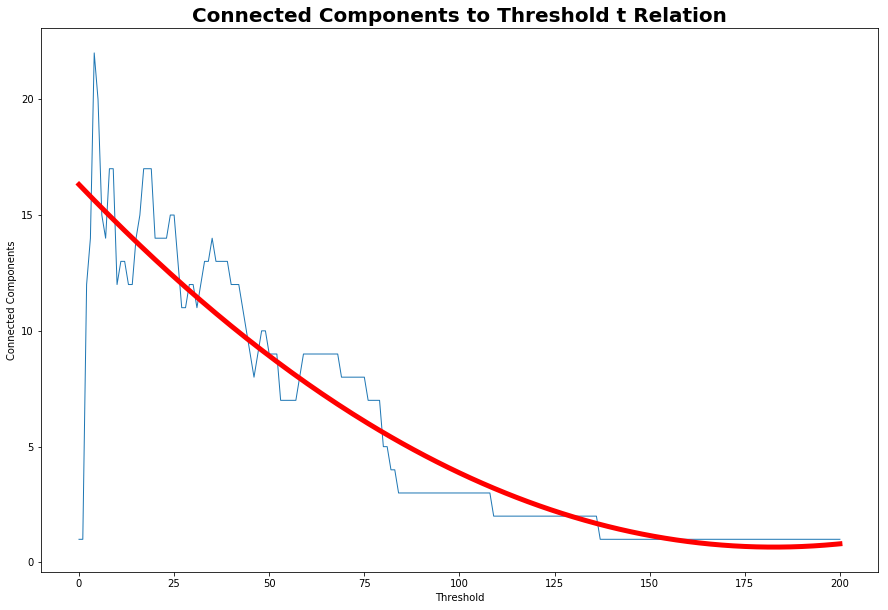

In [159]:
plotThrasholdRelationTo(coComp,"Connected Components")

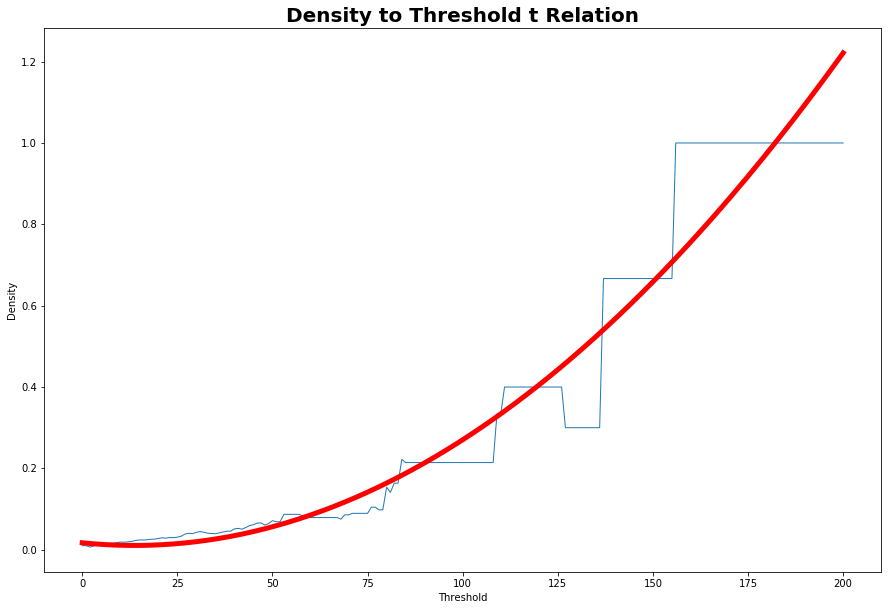

In [82]:
plotThrasholdRelationTo(density,"Density")

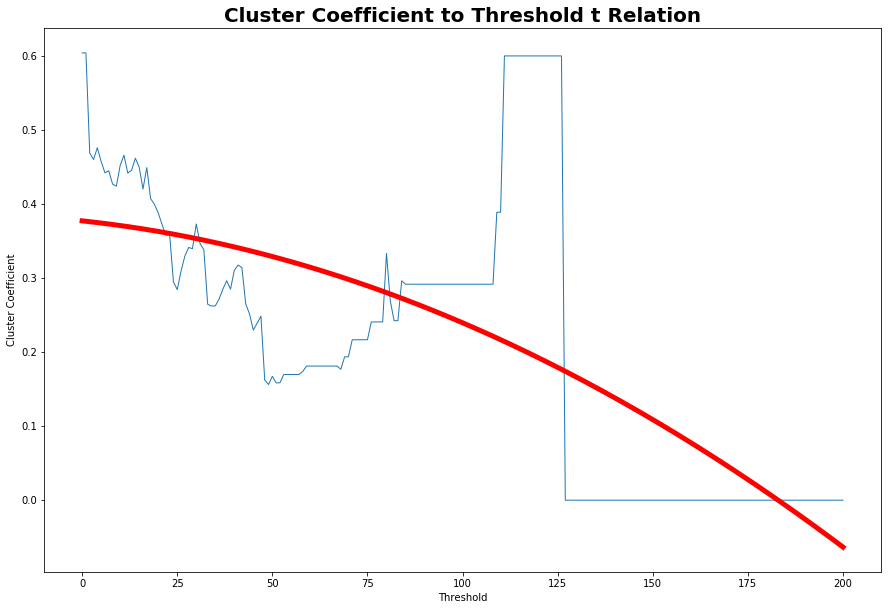

In [130]:
plotThrasholdRelationTo(clusCoef,"Cluster Coefficient")

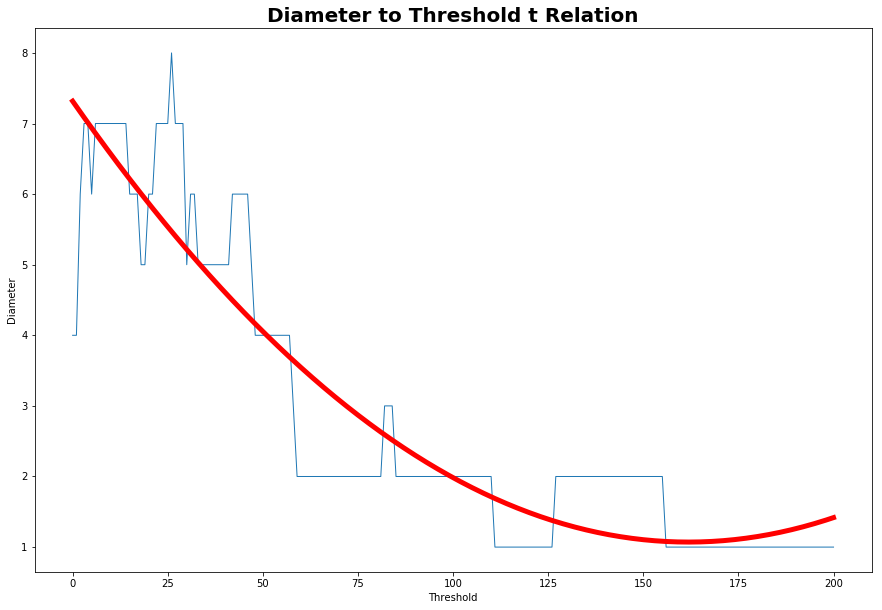

In [131]:
plotThrasholdRelationTo(diameter,"Diameter")

# Network Data Preparation

In this section we prepare the data for d3.

After creating the network object (GF) we can vizualize it using d3. For d3 we need to transform the graph data into json. For that reason we use a package from networkX called json_graph which provides us with node_link_data method. The json will be saved into force.json

In [112]:
# write json formatted data
d = json_graph.node_link_data(GF)  # node-link format to serialize

#### Network Example with D3
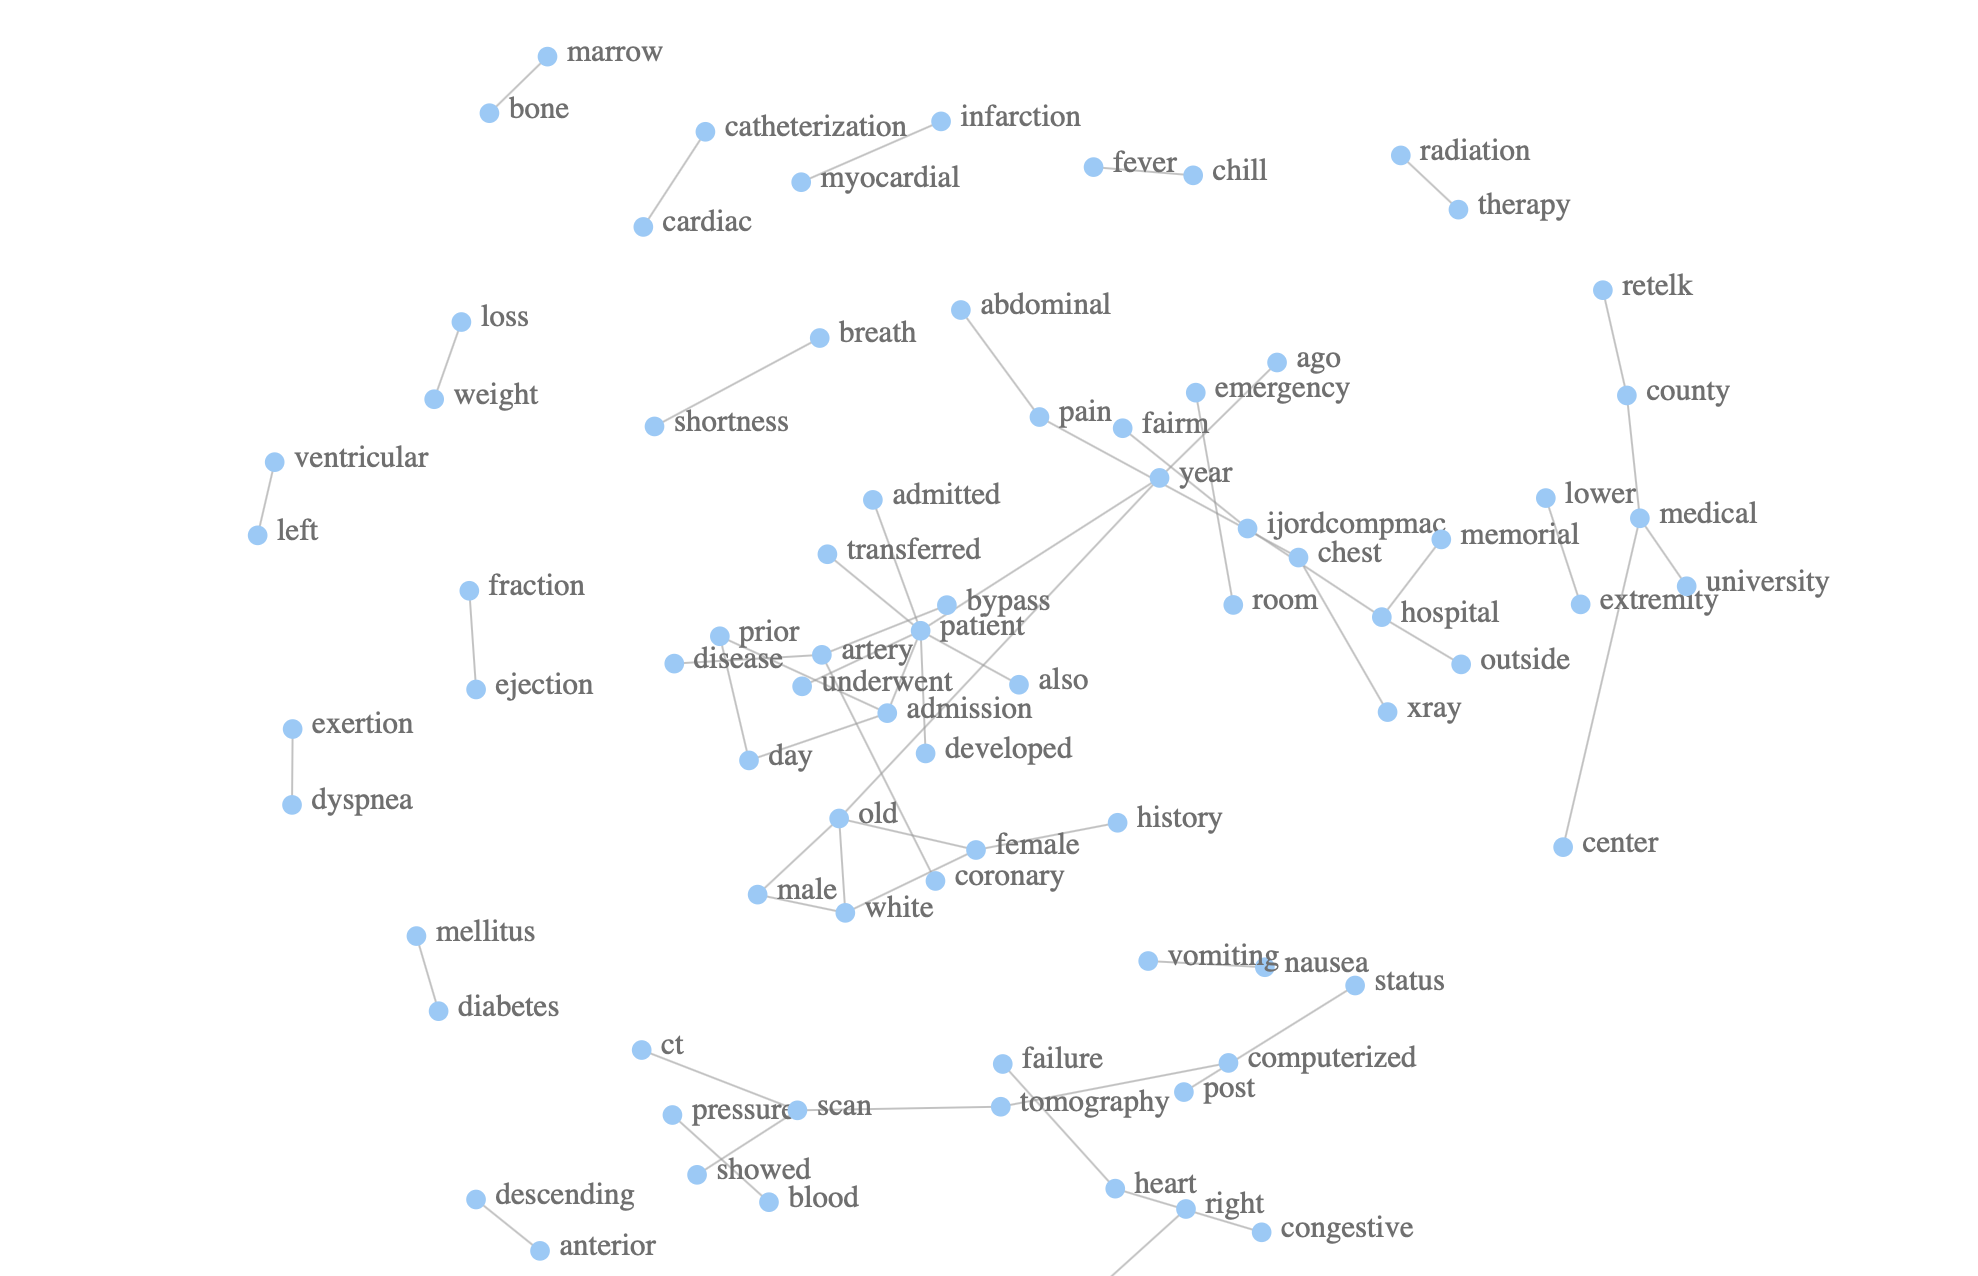

###### Centrality
The next step is to extend the graph with node importance information. For that reason we calculate the degree and closeness centrality.

In [113]:
degree_centrality = nx.degree_centrality(GF)
closeness_centrality = nx.closeness_centrality(GF)
# add node attributes to graph GF
nx.set_node_attributes(GF, degree_centrality, "degree_centrality")
nx.set_node_attributes(GF, closeness_centrality, "closeness_centrality")
# we reasign variable d because the graph data has been updated
d = json_graph.node_link_data(GF)

#### Network Example with D3 (Degree Centrality)
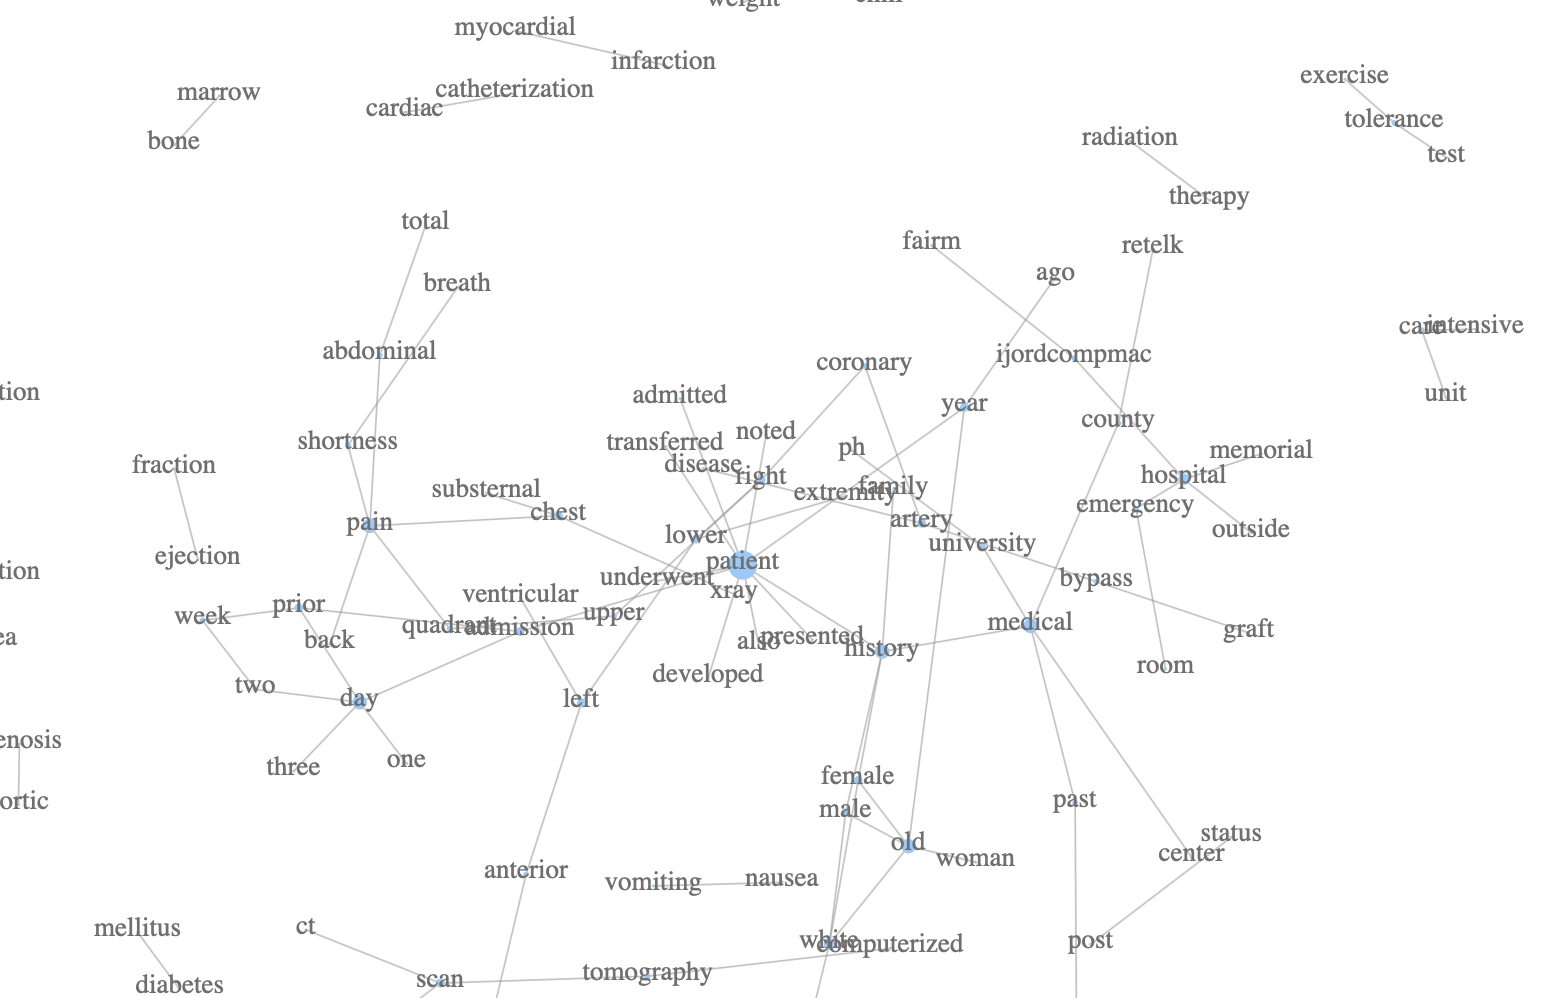

###### Community detection
Communities, or clusters, are usually groups of vertices having higher probability of being connected to each other than to members of other groups, though other patterns are possible. Identifying communities is an illdefined problem.

The algorith that we use to extract communities is called: [louvain](https://arxiv.org/pdf/0803.0476.pdf)<br>
Github repository: [here](https://github.com/taynaud/python-louvain)

In [114]:
# get partitions
partition = community.best_partition(GF)
# add partitions to the node attribute list
nx.set_node_attributes(GF, partition, "group")
# update d
d = json_graph.node_link_data(GF)

Save d into a json document

In [115]:
json.dump(d, open("force.json", 'w'))

##### force.json:
<span style="color:red">{</span>
  <div style="position:relative;left:30px">
  <span style="color:green">"directed"</span>: false,<br>
  <span style="color:green">"multigraph"</span>: false,<br>
  <span style="color:green">"graph"</span>: {},<br>
  <span style="color:green">"nodes"</span>: [<br>
    <div style="position:relative;left:30px">{
    <div style="position:relative;left:30px">
      <span style="color:orange">"degree_centrality"</span>: 0.18623232944068838,<br>
      <span style="color:orange">"closeness_centrality"</span>: 0.5509651202167287,<br>
        <span style="color:orange">"group"</span>: 1,<br>
      <span style="color:orange">"id"</span>: "year"<br>
    </div>
    },
    ...
    ]
    </div>
      <span style="color:green">"links"</span>: [<br>
    <div style="position:relative;left:30px">
    { <br>
        <div style="position:relative;left:30px">
          <span style="color:orange">"Weight"</span>: 8, <br>
          <span style="color:orange">"source"</span>: "year", <br>
          <span style="color:orange">"target"</span>: "old" <br>
         </div>
    },<br>
    ...
    ]</div>
   </div>
<span style="color:red">}</span>

###### POS tags
In this section we generate a json document that contains the POS tag for every node. The decided against adding an node attribute like we did before with centrality and community detection, because the POS tags are static and they are dependent on the text and not on the network.

generatePOSTagJson:
- descritption: this method generates for every node, its POS tag
- parameters: none
- returns: none

In [82]:
def generatePOSTagJson():
    text = normalizer.normalizeArray(df_xml.illness,True,True)
    # convert nd array to 1d
    nDimens = np.array(text)
    oneDimens = np.concatenate(nDimens)
    # interate throught every entry
    data = {}
    for entry in oneDimens:
        data[entry[0]]=entry[1]
    json.dump(data, open("POSTag.json", 'w'))

In [106]:
generatePOSTagJson()

generateTAGColorJson:
- description: this method generates random colors for every POS tag
- parameters: none
- returns: none

In [147]:
def generateTAGColorJson():
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    data = {}
    tags = tagdict.keys()
    for tag in tags:
        color = "%06x" % random.randint(0, 0xFFFFFF)
        data[tag] = "#"+color
    json.dump(data, open("TAGColor.json", 'w'))

In [148]:
generateTAGColorJson()

#### Summarize into one method
In this section we will summuraize the above mentioned steps into one function which allows us to create network size idependent json documents.

dynamicCustomAnalyser:
   - description: same function as customAnalyser from the data exploration part, but is more variable, meaning we can change how many tokens we want to skip and if we want 2,3,4,...-grams.
   - parameters:
       - token
       - n: stands for n in n-gram -> will default 2
       - k: is the skip window, is used to define how many tokens should be skipped. If 0 than we have a regular ngram
   - returns:  Function

In [89]:
def dynamicCustomAnalyser(token, n, k):
        return compose(cmap(' '.join), skipgrams)(token, n, k)

generateNetworkVisualisationData:
- decription: This function will include the previosly mentioned steps. Firstly creating the host json file in which the nodes the edges and the weigths are contained. Then the second step consist on extending this host json file with properties of network like the two centralities
- parameters: 
    - name: the name of the jso file
    - graph: the graph object
- returns: none    

In [116]:
def generateNetworkVisualisationData(name,t,relyOnEdgeWeight=False,tfidf=False,skip_window=0):
    # parse text
    text = normalizer.normalizeArray(df_xml.illness,True,False)
    # create n-grams
    vectorizer = CountVectorizer(analyzer= lambda token: dynamicCustomAnalyser(token,2,skip_window))
    if tfidf:
        # use tfidf vectorizer
        vectorizer = TfidfVectorizer(analyzer= lambda token: dynamicCustomAnalyser(token,2,skip_window))

    if(relyOnEdgeWeight):
        networkData = getFirstWordsWithCountGreater(vectorizer,text,t)
    else:
        networkData = getFirstNWords(vectorizer,text,t)
    
    # create pandas dataframe
    df_graph = createDataframe(networkData)
    # create graph object
    graph = nx.from_pandas_edgelist(df_graph, 'Node1', 'Node2', ["Weight"])
    
    ### extra information ###
    
    # calculate degree centrality
    degree_centrality = nx.degree_centrality(graph)
    # calculate closeness centrality    
    closeness_centrality = nx.closeness_centrality(graph)
    # calculate partition/group info
    partition = community.best_partition(graph)
    
    # add node attributes
    nx.set_node_attributes(graph, degree_centrality, "degree_centrality")
    nx.set_node_attributes(graph, closeness_centrality, "closeness_centrality")
    nx.set_node_attributes(graph, partition, "group")
    
    ### end ###
    
    # define the data extension
    dataExtension = "json"
    name = name + "." + dataExtension
    # create the json data
    data = json_graph.node_link_data(graph)
    # write data 
    json.dump(data, open(name, 'w'))

In [123]:
#test 
generateNetworkVisualisationData("force_100",100)

For the final visualization we build a [flask application](https://github.com/LaertNuhu/FlaskAPI) which servers as a api endpoint that servers us the data. This allows us to be more flexible and interactive with the data and load only what we need for the visualization. Disadvantage is that network connection is required and there is a slight delay before the data will be served.